In [1]:
import logging
from action_classification.skeleton_pipeline import Action_Recognizer
import cv2
from action_classification.ADModel import ADModel
import cv2
import numpy as np
import insightface
from insightface.app import FaceAnalysis
from insightface.model_zoo import model_zoo
from insightface.data import get_image as ins_get_image
import time

D:\Anaconda3\envs\open-mmlab\lib\site-packages\mmcv\cnn\bricks\transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '


In [9]:
from PIL import Image
def show_img(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    display(img)

In [2]:
model = model_zoo.get_model("checkpoints/models/buffalo_l/det_10g.onnx",providers=['CPUExecutionProvider'])

checkpoints/models/buffalo_l/det_10g.onnx
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


checkpoints/models\buffalo_l\1k3d68.onnx
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: checkpoints/models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
checkpoints/models\buffalo_l\2d106det.onnx
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: checkpoints/models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
checkpoints/models\buffalo_l\det_10g.onnx
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: checkpoints/models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
checkpoints/models\buffalo_l\genderage.onnx
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: checkpoints/models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
checkpoints/models\buffalo_l\w600k_r50.onnx
Applied providers: ['CPUExecutionProvider'], wit

f:\development\project\deep_learning_demo_object\master_v2\python-package\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


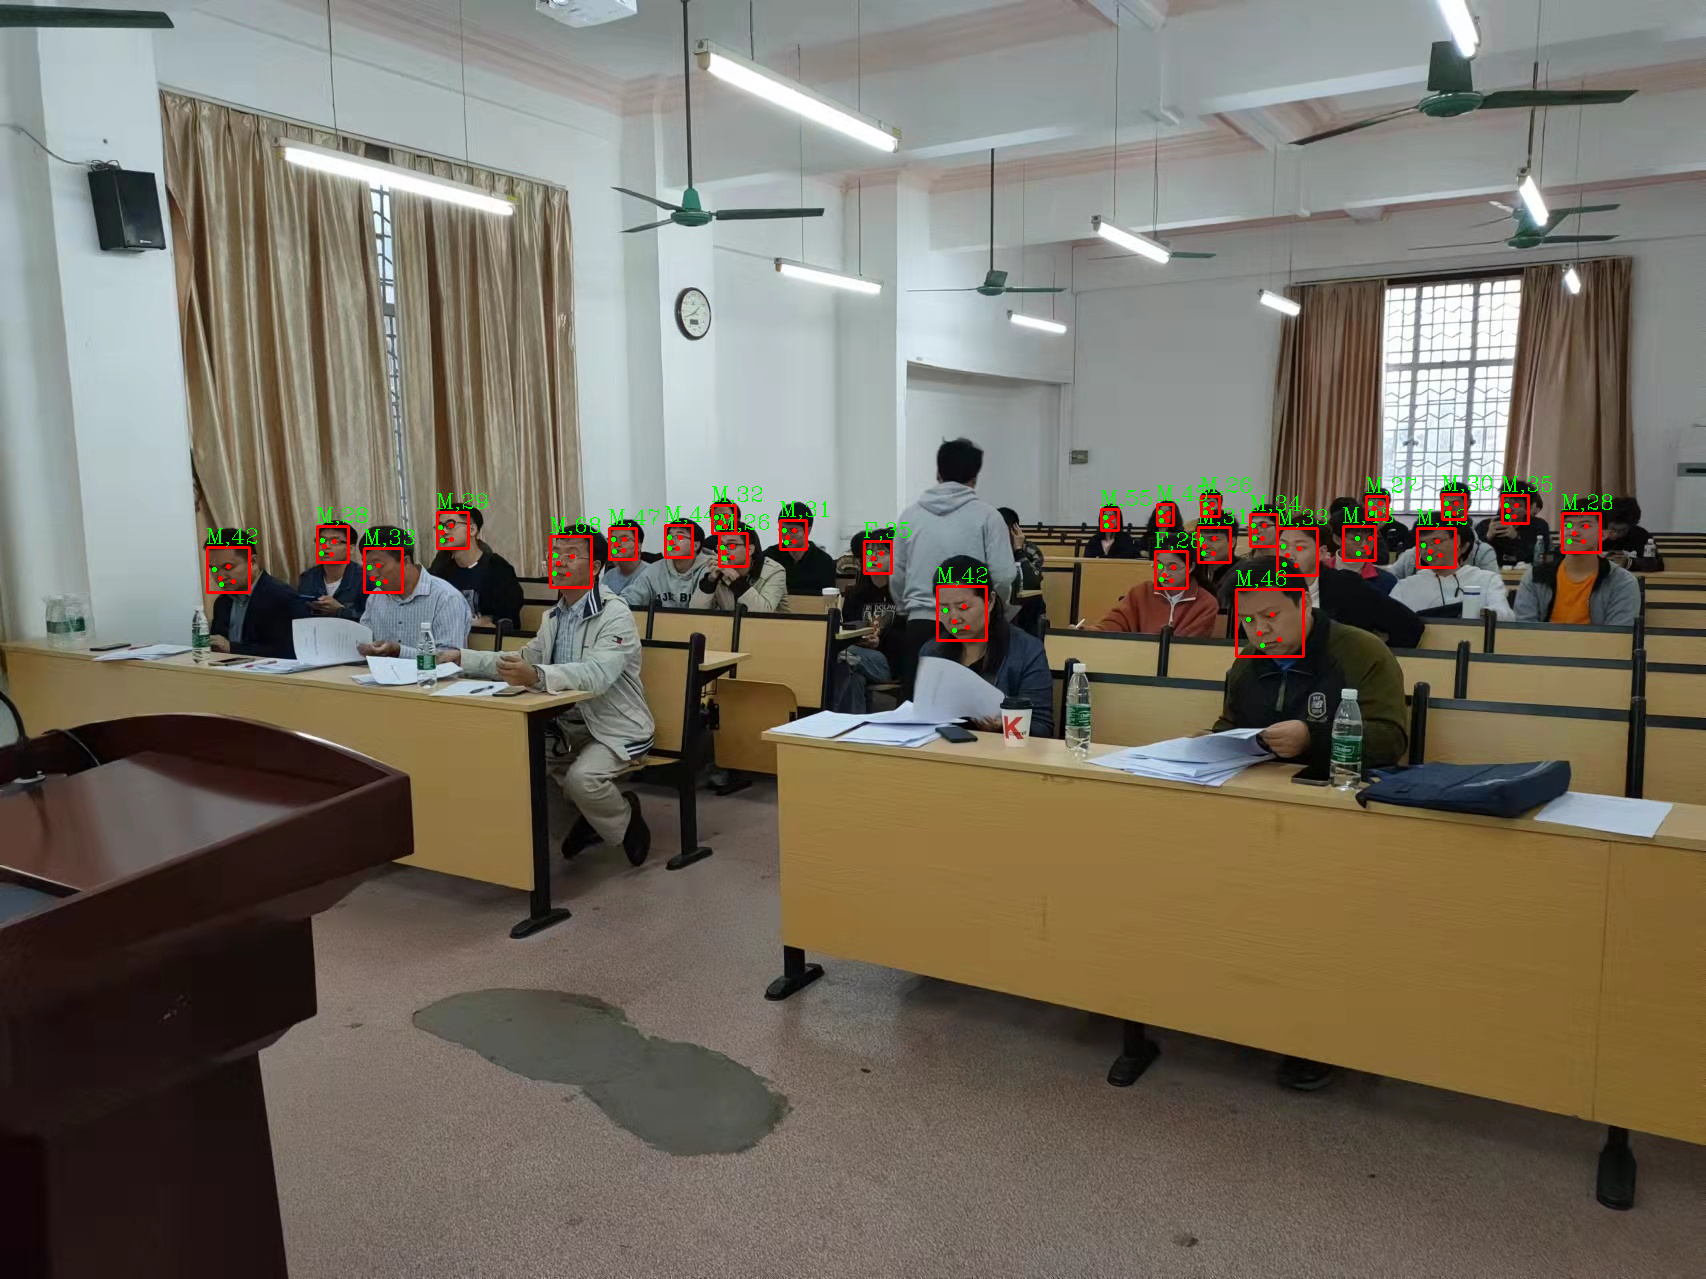

In [11]:
app = FaceAnalysis(root="checkpoints/",providers=['CPUExecutionProvider'])  # allowed_modules=['detection'],,'alignment'
img = cv2.imread("123.jpg")
app.prepare(ctx_id=0, det_size=(1120, 1600))

faces = app.get(img)
rimg = app.draw_on(img, faces)

# recognizer = Action_Recognizer()
#
# ac_img, labels = recognizer.process(img,is_show_keypoints=False)  #labels中包含 人体bbox
# cv2.imshow("123",rimg)
# cv2.waitKey(0)
show_img(rimg)

In [12]:
print(len(faces))
print(faces[1].keys())

26
dict_keys(['bbox', 'kps', 'det_score', 'landmark_3d_68', 'pose', 'landmark_2d_106', 'gender', 'age', 'embedding'])


In [16]:
len(faces[1]["embedding"])

512

In [ ]:
# landmark_3d_68 landmark_2d_106 detection genderage recognition
app = FaceAnalysis(root="checkpoints/",providers=['CPUExecutionProvider'],allowed_modules=['detection','recognition'])
#保存特征向量
with open("features_all.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    for person in person_list:
        
        if len(person.split('_', 2)) == 2:
            # "person_x"
            person_name = person
        else:
            # "person_x_tom"
            person_name = person.split('_', 2)[-1]
        features_mean_personX = np.insert(features_mean_personX, 0, person_name, axis=0)
        # features_mean_personX will be 129D, person name + 128 features
        writer.writerow(features_mean_personX)
        logging.info('\n')
    logging.info("所有录入人脸数据存入 / Save all the features of faces registered into: data/features_all.csv")


In [53]:
from __future__ import division
import glob
import os.path as osp
import numpy as np
import onnxruntime
from numpy.linalg import norm
from insightface.model_zoo import model_zoo
from insightface.utils import DEFAULT_MP_NAME, ensure_available
from insightface.app.common import Face
class extractor:
    def __init__(self, name="buffalo_l", root='checkpoints/', allowed_modules=['detection','recognition'], **kwargs):
        onnxruntime.set_default_logger_severity(3)
        self.models = {}
        self.model_dir = ensure_available('models', name, root=root)
        onnx_files = glob.glob(osp.join(self.model_dir, '*.onnx'))
        onnx_files = sorted(onnx_files)
        for onnx_file in onnx_files:
            model = model_zoo.get_model(onnx_file, **kwargs)
            if model is None:
                print('model not recognized:', onnx_file)
            elif allowed_modules is not None and model.taskname not in allowed_modules:
                print('model ignore:', onnx_file, model.taskname)
                del model
            elif model.taskname not in self.models and (allowed_modules is None or model.taskname in allowed_modules):
                print('find model:', onnx_file, model.taskname, model.input_shape, model.input_mean, model.input_std)
                self.models[model.taskname] = model
            else:
                print('duplicated model task type, ignore:', onnx_file, model.taskname)
                del model
        assert 'detection' in self.models
        self.det_model = self.models['detection']
        self.prepare(0)


    def prepare(self, ctx_id, det_thresh=0.5, det_size=(640, 640)):
        self.det_thresh = det_thresh
        assert det_size is not None
        print('set det-size:', det_size)
        self.det_size = det_size
        for taskname, model in self.models.items():
            if taskname=='detection':
                model.prepare(ctx_id, input_size=det_size, det_thresh=det_thresh)
            else:
                model.prepare(ctx_id)

    def features_extraction_to_csv(self, img_root,max_num=1):
        """
        img_root: 图片保存根目录
            img_root
                person_name
                    img1.jpg
                    img2.jpg
        """
        features_list = {}
        person_list = os.listdir(img_root) #名字列表
        for person in person_list:
            person_img_path = os.path.join(img_root,person)
            person_img_list = os.listdir(person_img_path)  #图片列表
            person_features = []
            for person_img in person_img_list:
                img_path = os.path.join(person_img_path,person_img)
                img = cv2.imread(img_path)
                print(img_path)
                bboxes, kpss = self.det_model.detect(img,
                                             max_num=max_num,
                                             metric='default')
                if bboxes.shape[0] == 0:
                    return []
                bbox = bboxes[0, 0:4]
                det_score = bboxes[0, 4]
                kps = None
                if kpss is not None:
                    kps = kpss[0]
                face = Face(bbox=bbox, kps=kps, det_score=det_score)
                for taskname, model in self.models.items():
                    if taskname=='detection':
                        continue
                    model.get(img, face)
                person_features.append(face["embedding"])
            features_list[person] = person_features
        return features_list



In [54]:
et = extractor(providers=['CPUExecutionProvider']) #providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
features_list = et.features_extraction_to_csv("face_database")
features_list

checkpoints/models\buffalo_l\1k3d68.onnx
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: checkpoints/models\buffalo_l\1k3d68.onnx landmark_3d_68
checkpoints/models\buffalo_l\2d106det.onnx
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: checkpoints/models\buffalo_l\2d106det.onnx landmark_2d_106
checkpoints/models\buffalo_l\det_10g.onnx
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: checkpoints/models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
checkpoints/models\buffalo_l\genderage.onnx
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: checkpoints/models\buffalo_l\genderage.onnx genderage
checkpoints/models\buffalo_l\w600k_r50.onnx
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: checkpoints/models\buffalo_l\w

{'luo': [array([ 0.42456502, -0.67309576, -0.19205576,  0.22646996,  0.23033065,
         -2.3182826 , -1.4032339 , -0.03363488, -1.1643198 , -0.8385413 ,
         -2.3010266 , -0.5961538 , -0.5247785 ,  1.59039   ,  1.1756843 ,
          0.35547933,  0.3932599 ,  1.4150673 ,  1.0277992 ,  0.05066378,
          0.48554188,  1.3088913 ,  0.6231924 ,  0.76543957,  0.08682858,
         -0.73799473,  0.64759004, -2.3956919 , -0.8608897 ,  0.29106876,
         -0.12609002,  1.3283514 ,  1.079569  , -0.18613078,  0.5473431 ,
         -0.42314535,  0.8545546 ,  0.3613575 , -0.2935424 ,  0.5488743 ,
         -0.8555365 , -0.46677944,  0.42584   , -0.124552  ,  1.2258835 ,
          1.810936  ,  0.6712419 ,  1.1070781 ,  0.46707475,  1.7212566 ,
          0.60575205,  0.11046498,  0.3569046 , -1.2891918 ,  0.1601839 ,
         -1.2104979 ,  1.1386477 , -0.20964324,  0.59364223,  0.74182254,
         -0.8252646 , -1.6082008 , -0.3196622 ,  1.2503655 , -0.20660442,
         -0.45067054,  0.622722

In [55]:
def read_pkl(file_dir):
    with open(file_dir,"rb") as fo:
        data = pickle.load(fo,encoding="bytes")
    return data

def save_pkl(file_name,data):
    with open(file_name,"wb") as fo:
        pickle.dump(data,fo)

In [56]:
import pickle
file_name = "face_database.pkl"
save_pkl(file_name,features_list)


In [57]:
face_database = read_pkl(file_name)
face_database

{'luo': [array([ 0.42456502, -0.67309576, -0.19205576,  0.22646996,  0.23033065,
         -2.3182826 , -1.4032339 , -0.03363488, -1.1643198 , -0.8385413 ,
         -2.3010266 , -0.5961538 , -0.5247785 ,  1.59039   ,  1.1756843 ,
          0.35547933,  0.3932599 ,  1.4150673 ,  1.0277992 ,  0.05066378,
          0.48554188,  1.3088913 ,  0.6231924 ,  0.76543957,  0.08682858,
         -0.73799473,  0.64759004, -2.3956919 , -0.8608897 ,  0.29106876,
         -0.12609002,  1.3283514 ,  1.079569  , -0.18613078,  0.5473431 ,
         -0.42314535,  0.8545546 ,  0.3613575 , -0.2935424 ,  0.5488743 ,
         -0.8555365 , -0.46677944,  0.42584   , -0.124552  ,  1.2258835 ,
          1.810936  ,  0.6712419 ,  1.1070781 ,  0.46707475,  1.7212566 ,
          0.60575205,  0.11046498,  0.3569046 , -1.2891918 ,  0.1601839 ,
         -1.2104979 ,  1.1386477 , -0.20964324,  0.59364223,  0.74182254,
         -0.8252646 , -1.6082008 , -0.3196622 ,  1.2503655 , -0.20660442,
         -0.45067054,  0.622722

In [68]:
import numpy as np
l1 = np.array([1,3,4,1])
l2 = np.array([3,4,5,6])
import math
l = l1-l2
np.square(l).sum()
np.sqrt(np.square(l).sum())

5.5677643628300215